In [11]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import calendar
import seaborn as sns
from matplotlib.pyplot import subplots, show
import ast
import math
import re
from scipy.stats import ttest_ind, mannwhitneyu, median_test
import missingno as msno
from IPython.display import display
from IPython.core.debugger import Tracer

%matplotlib inline

In [12]:
# change optional settings for libraries
sns.set_style("whitegrid")
pd.set_option('show_dimensions', False)
np.warnings.filterwarnings('ignore')

In [13]:
filename = ['processed.cleveland.data','processed.hungarian.data','processed.switzerland.data','processed.va.data']
colnames=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num']

In [14]:
heartdisease = []

for path in filename:
    tempdf = pd.read_csv('../data/' + path, names=colnames)
    tempname = re.findall(r'\.([a-z]*)\.',path)[0]
    # adds location of data to the dataframe
    tempdf['location'] = tempname
    heartdisease.append(tempdf)

heartdf = pd.concat(heartdisease)

In [15]:
heartdf['location'].loc[heartdf['num'] == 0].value_counts()

heartdf['location'] = pd.Categorical(heartdf['location'])

__Missing Data__

In [16]:
# check for missing data
heartdf = heartdf.replace('?',np.nan)

__Delete variables with large number of null values__

In [17]:
del heartdf['slope']
del heartdf['ca']
del heartdf['thal']

__Clean null value rows from dataframe and convert strings to floats__

In [21]:
heart = heartdf.loc[heartdf['chol'] != 0].dropna()

In [23]:
for column in heart.columns:
    if column != 'location':
        heart[column] = pd.to_numeric(heart[column])

__Data Summary:__

#  <span style="color:darkblue">Exploring the data</span>

__A. Scatterplot using univariate and bivariate methods__

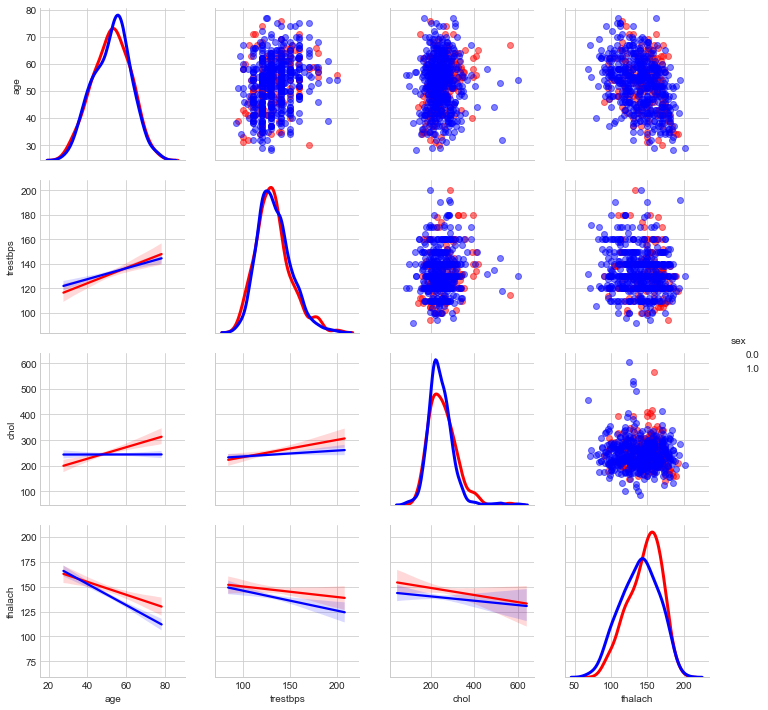

In [64]:
# Make the scatterplot matrix
collist = ['age','trestbps','chol','thalach']


g = sns.PairGrid(data=heart, diag_sharey=False, hue="sex", vars=collist, palette=['r','b'])
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)

g.add_legend()

plt.show()

#  <span style="color:darkblue">Feature Engineering

In [24]:
heart.head
heart.location.unique()

[cleveland, hungarian, va]
Categories (3, object): [cleveland, hungarian, va]

In [25]:
def dum_feat():
    # Making dummies.
    # Also creating a data frame to hold our features.
    features = pd.get_dummies(heart['num'])
    features['num'] = heart['num']
    features = features.drop(features.columns[0:5], axis=1)
    features['age'] = heart['age']
    features['exists'] = np.where(heart['num'] >= 1, 1, 0)
    features['gender'] = heart['sex']
    features['adult'] = np.where(heart['sex'] >= 18, 1, 0)

    features['chol'] = heart['chol']
    features['cholwarn'] = np.where(heart['chol'] >= 240, 1, 0)
    features['bp'] = heart['trestbps']
    features['bpwarn'] = np.where(heart['chol'] >= 140, 1, 0)
    loc = ['cleveland','va','hungarian']
    features['location'] = pd.Categorical(heart.location).codes
    return features

features = dum_feat()

#  <span style="color:darkblue">Principal Components Analysis

In [27]:
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

Actual Transformation

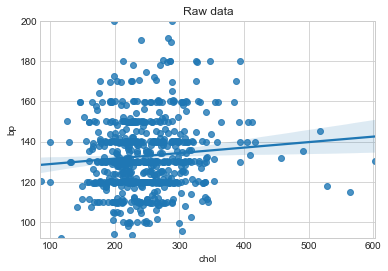

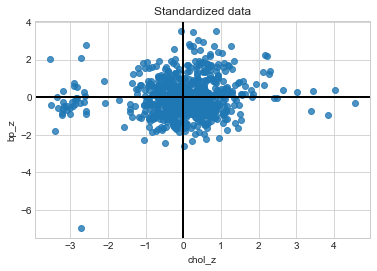

In [28]:
t = sns.regplot(
    'chol',
    'bp',
    features,
    x_jitter=.49,
    y_jitter=.49,
)
t.set(xlim=(85, 603), ylim=(92, 200))
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Raw data')
plt.show()

# Standardizing variables by subtracting the mean and dividing by the standard
# deviation. Now both variables are on the same scale.
features['chol_z'] = (features['chol'] - features['chol'].mean()) / features['chol'].std()
features['bp_z']  = (features['bp'] - features['bp'].mean()) / features['bp'].std()

t = sns.regplot(
    'chol_z',
    'bp_z',
    features,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)

t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Standardized data')
plt.show()

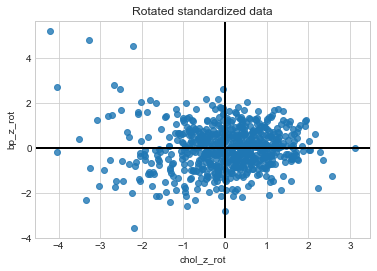

In [228]:
# Rotating the data so that the axes roughly match to vector above.
features['chol_z_rot'] = math.cos(40) * features['chol_z'] - math.sin(40) * features['bp_z']
features['bp_z_rot'] = math.sin(40) * features['chol_z'] + math.cos(40) * features['bp_z']

t = sns.regplot(
    'chol_z_rot',
    'bp_z_rot',
    features,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Rotated standardized data')
plt.show()

In [229]:
# Take a subset of the data for PCA and drop missing values because PCA cannot
# handle them.
features = dum_feat()

featuresco = features.drop(['num','exists','adult','cholwarn','bpwarn'], axis=1)
features.head()

,num,age,exists,gender,adult,chol,cholwarn,bp,bpwarn,location
0,0,63.0,0,1.0,0,233.0,0,145.0,1,0
1,2,67.0,1,1.0,0,286.0,1,160.0,1,0
2,1,67.0,1,1.0,0,229.0,0,120.0,1,0
3,0,37.0,0,1.0,0,250.0,1,130.0,1,0
4,0,41.0,0,0.0,0,204.0,0,130.0,1,0


In [230]:
# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(featuresco)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[ 1.00151515  0.01090197  0.09584531  0.26111555  0.03537025]
 [ 0.01090197  1.00151515 -0.08628839  0.02982717  0.18789817]
 [ 0.09584531 -0.08628839  1.00151515  0.1066408  -0.02843642]
 [ 0.26111555  0.02982717  0.1066408   1.00151515  0.08451635]
 [ 0.03537025  0.18789817 -0.02843642  0.08451635  1.00151515]]


In [231]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 5).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[[-0.61586433]
 [-0.15113814]
 [-0.31290591]
 [-0.64903329]
 [-0.28056027]]
Eigenvalue 1: 1.3441789949521397
----------------------------------------
Eigenvector 2: 
[[-0.14105795]
 [ 0.66542553]
 [-0.43576348]
 [-0.06429276]
 [ 0.58590797]]
Eigenvalue 2: 1.2182740203981033
----------------------------------------
Eigenvector 3: 
[[-0.66270812]
 [ 0.06498365]
 [-0.0487638 ]
 [ 0.71963118]
 [-0.19065184]]
Eigenvalue 3: 0.7341302363478907
----------------------------------------
Eigenvector 4: 
[[ 0.38633465]
 [-0.09440654]
 [-0.80915455]
 [ 0.20916272]
 [-0.37861963]]
Eigenvalue 4: 0.9048136982926667
----------------------------------------
Eigenvector 5: 
[[-0.11125317]
 [-0.72196306]
 [-0.23471491]
 [ 0.11403571]
 [ 0.63110763]]
Eigenvalue 5: 0.8061788075849521
----------------------------------------
The percentage of total variance in the dataset explained by each component calculated by hand.
 [0.26842909 0.24328619 0.14660392 0.18068897 0.16099183]


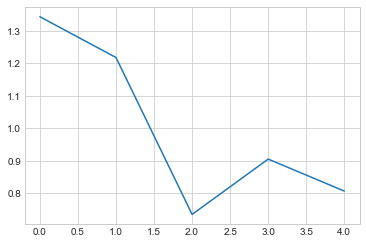

In [232]:
plt.plot(eig_val_cov)
plt.show()

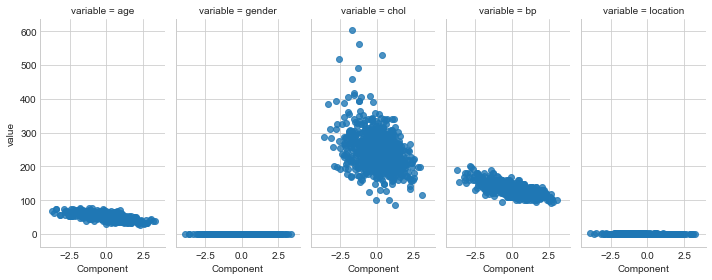

In [233]:
# Create P, which we will use to transform Cx into Cy to get Y, the
# dimensionally-reduced representation of X.
P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

# Combine X and Y for plotting purposes.
data_to_plot = features[['age','gender','chol','bp','location']]
data_to_plot['Component'] = Y
data_to_plot = pd.melt(data_to_plot, id_vars='Component')

g = sns.FacetGrid(data_to_plot, col="variable", size=4, aspect=.5)
g = g.map(
    sns.regplot,
    "Component",
    "value",
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
plt.show()

categorical variables?

In [239]:
sklearn_pca = PCA(n_components=5)
X = StandardScaler().fit_transform(featuresco)
Y_sklearn = sklearn_pca.fit_transform(X)

print(X)
print('')
print(Y_sklearn)

[[ 1.09931563  0.59074495 -0.2335795   0.68656523 -0.96576203]
 [ 1.52264662  0.59074495  0.68709902  1.53009611 -0.96576203]
 [ 1.52264662  0.59074495 -0.30306467 -0.71931958 -0.96576203]
 ...
 [ 0.14682092 -1.69277792  1.50354978 -0.32567183  1.84025424]
 [ 0.25265367  0.59074495 -0.40729243 -0.60684879  1.84025424]
 [ 0.99348289  0.59074495  0.13121765 -0.71931958  1.84025424]]

[[ 8.67874208e-01  2.70173866e-01 -1.06719576e+00 -1.02518062e+00
  -5.48351926e-04]
 [ 1.96415404e+00  7.85319072e-01 -6.62207185e-01 -1.19218187e+00
   2.81042115e-01]
 [ 1.94380296e-01  2.09220746e-01 -9.92908742e-01 -1.21628940e+00
  -1.28942342e+00]
 ...
 [ 6.09978440e-01  7.03162016e-01  1.76494761e+00  1.97714354e+00
  -8.65832569e-01]
 [ 2.39877412e-01 -1.65217674e+00  4.52285321e-01  7.33189106e-01
  -8.96740919e-01]
 [ 7.91633408e-01 -1.32024492e+00  6.25339896e-01  5.11547471e-01
  -1.49489174e+00]]


The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.26842909 0.24328619 0.18068897 0.16099183 0.14660392]


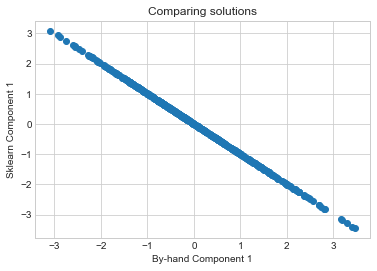

In [234]:
print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()